In [4]:
{-# LANGUAGE DerivingStrategies #-}
{-# LANGUAGE GeneralizedNewtypeDeriving #-}
{-# LANGUAGE FlexibleInstances #-}

module CIO where

import Control.Monad.Reader
import IHaskell.Display as IHaskell
import IHaskell.Types as Types
import qualified Database.LevelDB as DB
import qualified Data.HashMap.Strict as Map
import qualified Data.HashSet as Set
import Control.Monad.Trans.Resource
import Data.Default

newtype CIO a = CIO { unCIO :: ReaderT DB.DB (ResourceT IO) a }
    deriving newtype (Functor, Applicative, Monad, MonadReader DB.DB, MonadIO)
    
runCIO :: CIO a -> IO a
runCIO (CIO io) = runResourceT $ do
    db <- DB.open ".cache" def {DB.createIfMissing = True}
    runReaderT io db

instance {-# OVERLAPPING #-} Show a => IHaskell.IHaskellDisplay (CIO [a]) where
    display cio = do
        res <- runCIO cio
        pure $ IHaskell.ManyDisplay $ (\x -> IHaskell.Display [IHaskell.plain $ show x]) <$> res    
        
instance {-# OVERLAPPING #-} Show a => IHaskell.IHaskellDisplay (CIO (Set.HashSet a)) where
    display = display . fmap Set.toList
instance {-# OVERLAPPING #-} (Show k, Show a) => IHaskell.IHaskellDisplay (CIO (Map.HashMap k a)) where
    display = display . fmap Map.toList

instance Show a => IHaskell.IHaskellDisplay (CIO a) where
    display cio = do
        res <- runCIO cio
        pure $ IHaskell.Display [IHaskell.plain $ show res]


In [5]:
{-# LANGUAGE LambdaCase #-}
{-# LANGUAGE TemplateHaskell #-}
{-# LANGUAGE DeriveGeneric #-}
{-# LANGUAGE RankNTypes #-}
{-# LANGUAGE OverloadedStrings #-}


import qualified Crypto.Hash.SHA256 as SHA256
import qualified Data.Binary as B
import Control.Monad.Reader
import GHC.Generics (Generic)
import Data.ByteString.Lens
import qualified Data.ByteString.Char8 as BS8
import qualified Database.LevelDB as DB
import qualified Data.ByteString.Lazy as BL
import Data.Conduit
import Data.Default
import Control.Lens
import Network.Wreq hiding (getWith, get, responseLink, Response, responseBody)
import qualified Network.Wreq as Wreq
import Data.Aeson.Lens


data Response = Response 
    { _responseLink :: Maybe String
    , _responseBody :: BL.ByteString }
    deriving (Generic, Show)
    
instance B.Binary Response
    
makeLenses ''Response

getWith :: Options -> String -> CIO Response
getWith opts url = do
    db <- ask
    DB.get db def key >>= \case
        Just resp -> pure $ B.decode $ BL.fromStrict resp
        Nothing -> do
            x <- liftIO $ Wreq.getWith opts url
            let resp = Response 
                    { _responseBody = (x^.Wreq.responseBody) 
                    , _responseLink = (x^?Wreq.responseLink "rel" "next".linkURL.unpackedChars)
                    }
            DB.put db def key (BL.toStrict $ B.encode resp)
            pure resp
  where
    key = SHA256.hash (BS8.pack $ show (opts, url))
    
getAllWith :: Options -> String -> Producer CIO Response
getAllWith = fix $ \loop opts url -> do
    resp <- lift $ getWith opts url
    yield resp
    mapM_ (loop (opts&params.~[])) (_responseLink resp)

In [6]:
print5 = mapM_ print . take 5

r <- Wreq.get "https://api.github.com/search/repositories?q=language:haskell&sort=stars"

print5 $ r ^.. Wreq.responseBody . key "items" . values . key "full_name" . _String

"jgm/pandoc"
"koalaman/shellcheck"
"PostgREST/postgrest"
"purescript/purescript"
"elm/compiler"

In [7]:
r <- Wreq.get "https://api.github.com/repos/jgm/pandoc/contributors" -- COPY from slide
print5 $ r ^.. Wreq.responseBody . values .  key "login" . _String

"jgm"
"jkr"
"tarleb"
"labdsf"
"mpickering"

In [8]:
r <- Wreq.get "https://api.github.com/users/jgm" -- COPY from slide
r ^. Wreq.responseBody . key "location" . _String

"Berkeley, CA"

In [9]:
import qualified Data.Text.IO as T

geonamesUsername <- T.readFile ".geonames-username"

In [10]:
r <- runCIO $ getWith
    (defaults & param "username" .~ [geonamesUsername] & param "q" .~ ["Berkeley, CA"])
    "http://api.geonames.org/searchJSON"
r ^. responseBody . key "geonames" . nth 0 . key "countryCode" . _String

"US"

In [11]:
r <- runCIO $ getWith (defaults & param "username" .~ [geonamesUsername] & param "country" .~ ["US"]) 
    "http://api.geonames.org/countryInfoJSON"
r ^. responseBody . key "geonames" . nth 0 . key "countryName" . _String
r ^. responseBody . key "geonames" . nth 0 . key "population" . _String

"United States"

"310232863"

In [12]:
pure 4 :: CIO Int

4

In [13]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}

import Data.String (IsString)
import qualified Data.Text as T

newtype GithubRepo = GithubRepo { unGithubRepo :: T.Text } deriving (IsString, Show)
newtype GithubUser = GithubUser { unGithubUser :: T.Text } deriving (IsString, Show)
newtype CountryCode = CountryCode { unCountryCode :: T.Text } deriving (IsString, Show)
newtype CountryName = CountryName { unCountryName :: T.Text } deriving (IsString, Show)
newtype CountryPopulation = CountryPopulation { unCountryPopulation :: Int } 
    deriving (Num, Enum, Eq, Ord, Real, Integral, Show)

data Country = Country 
    { countryName :: CountryName
    , countryPopulation :: CountryPopulation
    } deriving Show

In [14]:
import Data.Semigroup

githubAPI :: String
geonamesAPI :: String

githubAPI = "https://api.github.com"
geonamesAPI = "http://api.geonames.org"

githubAPISearchRepos :: String
githubAPIRepos :: GithubRepo -> String
githubAPIUsers :: GithubUser -> String
githubAPIRepoContributors :: GithubRepo -> String
geonamesAPISearch :: String
geonamesAPICountryInfo :: String

githubAPISearchRepos = githubAPI <> "/search/repositories"
githubAPIRepos (GithubRepo repo) = githubAPI <> "/repos/" <> T.unpack repo
githubAPIUsers (GithubUser user) = githubAPI <> "/users/" <> T.unpack user
githubAPIRepoContributors repo = githubAPIRepos repo <> "/contributors"
geonamesAPISearch = geonamesAPI <> "/searchJSON"
geonamesAPICountryInfo = geonamesAPI <> "/countryInfoJSON"

In [15]:
import Control.Monad

geonamesError r = r ^? responseBody . key "status" . to show

findCountryCode :: T.Text -> CIO (Maybe CountryCode)
findCountryCode location = do
    r <- getWith opts geonamesAPISearch
    forM_ (geonamesError r) $ \e ->
        fail ("At " <> T.unpack location <> ": " <> e)
    pure $ CountryCode <$> 
        r ^? responseBody 
            . key "geonames" 
            . nth 0
            . key "countryCode"
            . _String
  where
    opts = 
        defaults 
            & param "q" .~ [location] 
            & param "username" .~ [geonamesUsername]

In [16]:
findCountryCode "massachusetts"

Just (CountryCode {unCountryCode = "US"})

In [17]:
countryByCountryCode :: CountryCode -> CIO (Maybe Country)
countryByCountryCode (CountryCode code) = do
    r <- getWith opts geonamesAPICountryInfo
    forM_ (geonamesError r) $ \e -> 
        fail ("At " <> T.unpack code <> ": " <> e)
    pure $ Country 
        <$> (fmap CountryName $ r
                ^? responseBody 
                . key "geonames" 
                . nth 0 
                . key "countryName" 
                . _String) 
        <*> (fmap CountryPopulation $ r 
                ^? responseBody
                . key "geonames"
                . nth 0
                . key "population"
                . _String
                . to (read . T.unpack))     
  where
    opts = 
      defaults
          & param "country" .~ [ code ]
          & param "username" .~ [ geonamesUsername ]

In [18]:
countryByCountryCode "CH"

Just (Country {countryName = CountryName {unCountryName = "Switzerland"}, countryPopulation = CountryPopulation {unCountryPopulation = 7581000}})

In [19]:
import qualified Data.ByteString as BS

githubAuth <- oauth2Token <$> BS.readFile ".github-api-token"

In [20]:
import Control.Monad.Trans.Maybe

githubUserCountry :: GithubUser -> CIO (Maybe Country)
githubUserCountry user = runMaybeT $ do
    location <- MaybeT $ getLocation <$> fetchUser
    code <- MaybeT $ findCountryCode location
    MaybeT $ countryByCountryCode code
  where
    fetchUser = getWith opts $ githubAPIUsers user
    getLocation r = r ^? responseBody . key "location" . _String
    opts = defaults & auth ?~ githubAuth

In [21]:
githubUserCountry "nmattia"

Just (Country {countryName = CountryName {unCountryName = "Switzerland"}, countryPopulation = CountryPopulation {unCountryPopulation = 7581000}})

In [22]:
import qualified Data.Conduit.Combinators as C

        
topRepos :: T.Text -> Producer CIO GithubRepo   
topRepos language = 
    getAllWith opts githubAPISearchRepos
    .| awaitForever (C.yieldMany . fmap GithubRepo . getFullName)
  where
    getFullName r = 
      r ^.. responseBody . key "items" . values . key "full_name" . _String
    opts = defaults 
        & param "q" .~ ["language:" <> language]
        & param "sort" .~ ["stars"]
        & param "per_page" .~ ["100"]
        & auth ?~ githubAuth

In [23]:
sourceToList $ topRepos "haskell" .| C.take 5

GithubRepo {unGithubRepo = "jgm/pandoc"}

GithubRepo {unGithubRepo = "koalaman/shellcheck"}

GithubRepo {unGithubRepo = "PostgREST/postgrest"}

GithubRepo {unGithubRepo = "purescript/purescript"}

GithubRepo {unGithubRepo = "elm/compiler"}

In [24]:
repoContributors :: GithubRepo -> Producer CIO GithubUser
repoContributors repo = 
    getAllWith opts (githubAPIRepoContributors repo)
    .| awaitForever (C.yieldMany . fmap GithubUser . getLogin)
  where
    getLogin r = r ^.. responseBody .values.key "login" . _String
    opts = defaults 
        & param "per_page" .~ ["100"]
        & auth ?~ githubAuth

In [25]:
-- COPY from above
-- topRepos -> repoContributors
sourceToList $ repoContributors "jgm/pandoc" .| C.take 5

GithubUser {unGithubUser = "jgm"}

GithubUser {unGithubUser = "jkr"}

GithubUser {unGithubUser = "tarleb"}

GithubUser {unGithubUser = "labdsf"}

GithubUser {unGithubUser = "mpickering"}

In [26]:
-- COPY from "topRepos"
-- ADD awaitForever repoContributors
sourceToList $ topRepos "haskell" .| awaitForever repoContributors .| C.take 5

GithubUser {unGithubUser = "jgm"}

GithubUser {unGithubUser = "jkr"}

GithubUser {unGithubUser = "tarleb"}

GithubUser {unGithubUser = "labdsf"}

GithubUser {unGithubUser = "mpickering"}

In [27]:
{-# LANGUAGE LambdaCase #-}

import qualified Data.HashSet as Set
import Data.Hashable (Hashable(..))

accumulateUniques :: (Eq a, Hashable a) => Int -> Sink a CIO (Set.HashSet a)
accumulateUniques n = go mempty
    where
      go acc = await >>= \case
          Just x | Set.size acc < n -> go (Set.insert x acc)
          _ -> pure acc    

In [28]:
-- WRITE
C.yieldMany ["foo", "bar", "bar", "baz", undefined] $$ accumulateUniques 3

"baz"

"foo"

"bar"

In [29]:
{-# LANGUAGE StandaloneDeriving #-}

deriving instance Eq GithubUser
deriving instance Hashable GithubUser

In [30]:

-- WRITE
someUsers = runConduit $
    topRepos "haskell" 
    .| awaitForever repoContributors
    .| accumulateUniques 5
    
someUsers
    
-- print5 $ Set.toList users

GithubUser {unGithubUser = "jkr"}

GithubUser {unGithubUser = "tarleb"}

GithubUser {unGithubUser = "jgm"}

GithubUser {unGithubUser = "mpickering"}

GithubUser {unGithubUser = "labdsf"}

In [31]:
import qualified Data.HashMap.Strict as Map
import Control.Monad

deriving instance Eq CountryPopulation
deriving instance Eq CountryName
deriving instance Eq Country
instance Hashable Country where hashWithSalt s = hashWithSalt s . unCountryName . countryName
            
userCountries :: Set.HashSet GithubUser -> CIO (Map.HashMap Country Int)
userCountries cs = -- cached githubUserCountry $ \githubUserCountry' ->
  foldM 
    (\m u -> githubUserCountry u >>= \case
        Nothing -> pure m
        Just c -> pure $ Map.insertWith (+) c 1 m    
    ) Map.empty (Set.toList cs)

In [34]:
userCountries =<< someUsers

(Country {countryName = CountryName {unCountryName = "United Kingdom"}, countryPopulation = CountryPopulation {unCountryPopulation = 62348447}},1)

(Country {countryName = CountryName {unCountryName = "United States"}, countryPopulation = CountryPopulation {unCountryPopulation = 310232863}},1)

(Country {countryName = CountryName {unCountryName = "Germany"}, countryPopulation = CountryPopulation {unCountryPopulation = 81802257}},1)

In [33]:
import Graphics.Rendering.Chart 
import Graphics.Rendering.Chart.Backend.Cairo
import Data.Default.Class
import Control.Lens

chart :: String -> [(Country, Double)] -> Renderable ()
chart title cs = toRenderable layout 
  where
    layout = pie_title .~ title
           $ pie_plot . pie_data .~ map pitem values
           $ def
    values = take 10
           . (ix 0. _3 .~ 20) 
           . fmap (\(c, val) -> (T.unpack $ unCountryName $ countryName c, val, 0))
            $ cs
    pitem (s,v,o) = pitem_value .~ v
                  $ pitem_label .~ s
                  $ pitem_offset .~ o
                  $ def

In [36]:
import Data.Bifunctor
import Data.List

Users: 100

Countries: 23

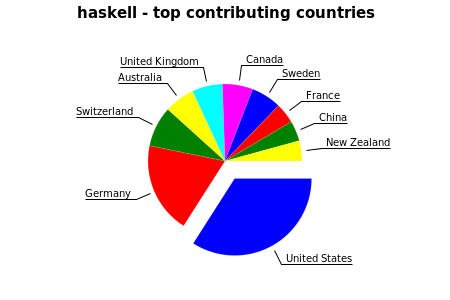

In [40]:

let lang = "haskell"
    title = "top contributing countries"

users <- runCIO $ topRepos lang $$ awaitForever repoContributors .| accumulateUniques 100
    
countries <- runCIO $ userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
    . fmap (second fromIntegral)
    $ Map.toList countries

In [ ]:
let lang = "haskell"
    title = "top contributing countries, scaled, filterd"

users <- topRepos lang $$ awaitForever repoContributors .| accumulateUniques 100
    
countries <- userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
    . fmap (\(c, n) -> (c, n / fromIntegral (countryPopulation c)))
    . filter ((> 1000000) . countryPopulation . fst)
    . fmap (second fromIntegral)
    $ Map.toList countries

In [ ]:
let lang = "haskell"
    title = "top contributing countries, scaled, filterd"

users <- topRepos lang $$ awaitForever repoContributors .| accumulateUniques 3000
    
countries <- userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
    . fmap (\(c, n) -> (c, n / fromIntegral (countryPopulation c)))
    . fmap (second fromIntegral)
    . filter ((> 1000000) . countryPopulation . fst)
    $ Map.toList countries

In [ ]:
Map.filterWithKey (\c _ -> countryName c == "India") countries -- WRITE